In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
dataset_name = 'horses_or_humans'
train_dataset = tfds.load(name=dataset_name,split='train[:80%]')
valid_dataset = tfds.load(name=dataset_name,split='train[80%:]')

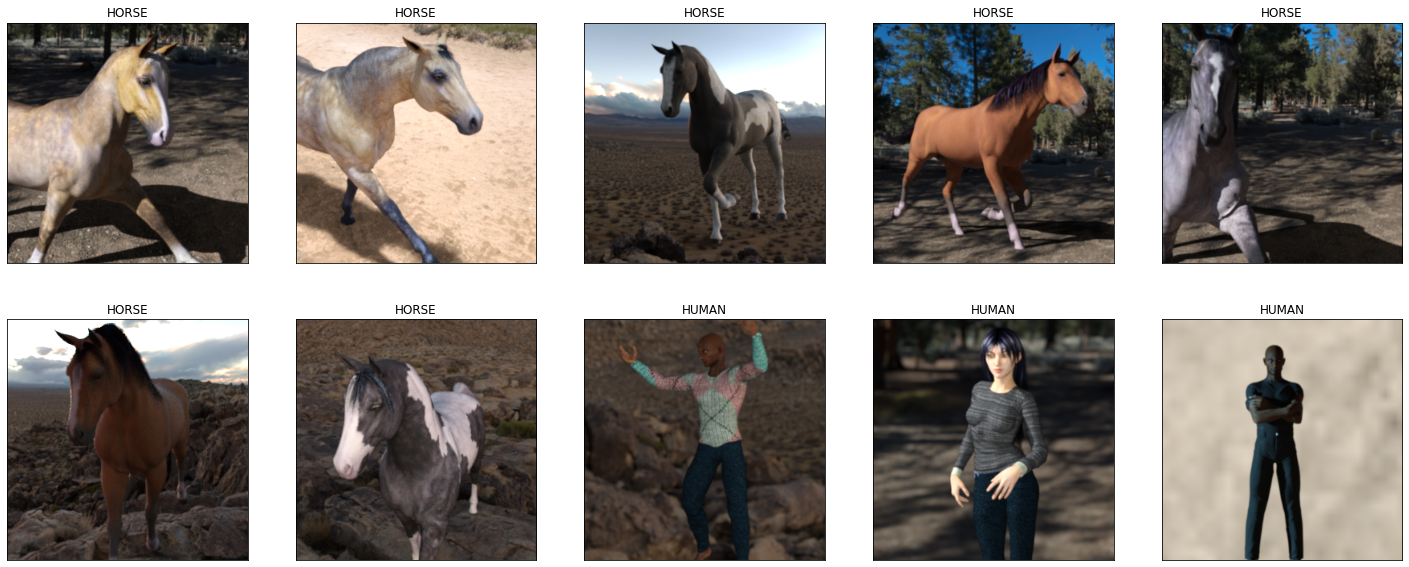

In [3]:
# 데이터 시각화
images = []
labels = []

for data in train_dataset.take(10):
    images.append(data['image'])
    labels.append(data['label'])

fig, axes = plt.subplots(2,5, figsize=(25, 10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx])
    ax.tick_params(bottom=False, labelbottom=False,
                   left=False, labelleft=False)
    
    if labels[idx] == 1:
        ax.set_title('HUMAN') # 사람이면 title:HUMAN
    else:
        ax.set_title('HORSE') # 그렇지 않으면 title:HORSE

In [4]:
# 데이터 전처리
def preprocessing(data):
    image = data['image']/255
    label = data['label']
    return image, label

train_data = train_dataset.map(preprocessing).batch(32).shuffle(1000)
valid_data = valid_dataset.map(preprocessing).batch(16)

In [5]:
# 모델링
model = tf.keras.models.Sequential([
        # feature extraction
        tf.keras.layers.Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(300,300,3)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        
        # fully-connected
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(32,activation='relu'),    
        tf.keras.layers.Dense(2, activation='softmax') # 왜 sigmoid가 안될까,,,,,
    ])


In [6]:
# 모델 요약 정보
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9

In [7]:
# 모델 최적화함수, 손실함수, 평가지표 정의
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # output에서 activation을 softmax를 썼기때문 
              metrics=['acc'])

In [8]:
# 체크 포인트 설정
checkpoint_path = 'my_checkpont.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True, # 가중치만 저장
                                                save_best_only=True, # 성능 개선이 있을때만 저장
                                                monitor = 'val_loss', # validation_loss값 모니터
                                                verbose=1 # 추적하는것을 화면에 표시
                                                )

In [9]:
# 모델 학습
history = model.fit(train_data,
            validation_data=(valid_data),
            epochs=20,
            callbacks=[checkpoint])

Epoch 1/20
26/26 [==============================] - 11s 181ms/step - loss: 0.4125 - acc: 0.7956 - val_loss: 0.3127 - val_acc: 0.8829

Epoch 00001: val_loss improved from inf to 0.31269, saving model to my_checkpont.ckpt
Epoch 2/20
26/26 [==============================] - 7s 127ms/step - loss: 0.1746 - acc: 0.9392 - val_loss: 0.0769 - val_acc: 0.9756

Epoch 00002: val_loss improved from 0.31269 to 0.07685, saving model to my_checkpont.ckpt
Epoch 3/20
26/26 [==============================] - 7s 128ms/step - loss: 0.0644 - acc: 0.9757 - val_loss: 0.0934 - val_acc: 0.9512

Epoch 00003: val_loss did not improve from 0.07685
Epoch 4/20
26/26 [==============================] - 7s 127ms/step - loss: 0.0358 - acc: 0.9866 - val_loss: 0.0233 - val_acc: 0.9902

Epoch 00004: val_loss improved from 0.07685 to 0.02330, saving model to my_checkpont.ckpt
Epoch 5/20
26/26 [==============================] - 7s 130ms/step - loss: 0.0180 - acc: 0.9951 - val_loss: 0.0221 - val_acc: 0.9951

Epoch 00005: val_

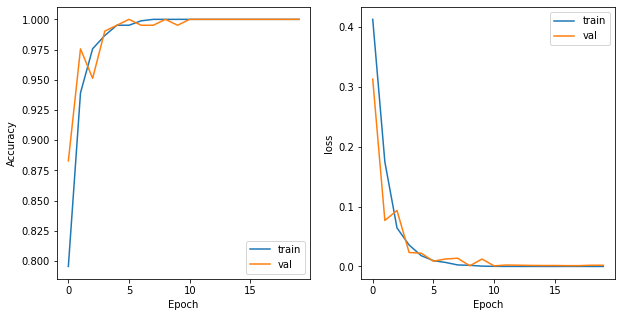

In [35]:
# train_loss, train_acc, val_loss, val_acc 시각화
fig, axes = plt.subplots(1,2, figsize=(10, 5))

# Accuracy
axes[0].plot(history.history['acc'], label='train')
axes[0].plot(history.history['val_acc'], label='val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [27]:
# 모델에 가중치 적용
model.load_weights(checkpoint_path)

In [33]:
# 모델 저장
model.save('horses-or-humans.h5')